In [1]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
from scripts.ising_simulation import IsingSimulation
from joblib import Parallel, delayed
from scipy import optimize


In [2]:
bold = np.loadtxt('../data/50003_timeseries.txt')
bold_bin = np.zeros(bold.shape)
bold_bin[np.where(bold>=0)] = 1
bold_bin[np.where(bold<0)] = -1
n_rois = bold_bin.shape[1]
n_timesteps = bold_bin.shape[0]

In [3]:
beta = 0.1
state = bold_bin
state.shape

(196, 116)

In [67]:
def loss(J, s):
#     print(s.shape)
    J = np.reshape(J, (n_rois, n_rois))
#     print(J.shape)
    term1 = 0
    term2 = 0
    for t in range(n_timesteps):
        C = beta * J @ s[t].T
        term1 += C @ s[t].T
        term2 -= np.sum(np.log(np.exp(C) + np.exp(-C)))
    return (term1+term2)/n_timesteps

def gradient(J, s):
    J = np.reshape(J, (n_rois, n_rois))
    grad = np.zeros((n_rois, n_rois))
    for t in range(n_timesteps):
        C = beta * J @ s[t].T
        grad += np.outer(s[t], s[t].T) - np.outer(np.tanh(C).T, s[t])
    grad = grad * beta/n_timesteps
    return grad.flatten()

In [74]:
def gradient_ascent(max_iterations,w_init,
                     obj_func,grad_func,extra_param = [],
                     learning_rate=0.05,momentum=0.8, threshold=0.005):
    
    w = w_init
    w_history = [w]
    f_history = [obj_func(w,extra_param)]
    delta_w = np.zeros(w.shape)
    i = 0
    diff = 1.0e10
    
    while i<max_iterations:
        grad = grad_func(w,extra_param)
        # print("from func", grad.shape)
        grad = np.reshape(grad, (n_rois, n_rois))
        # print(grad.shape)
        delta_w = learning_rate*grad
        w = w+delta_w
        w_history.append(w)
        f_history.append(obj_func(w,extra_param))
        if i%10 == 0: 
            print(f"iteration: {i} loss: {f_history[-1]} grad: {np.sum(grad)}")
        i+=1
        diff = np.absolute(f_history[-1]-f_history[-2])
    
    return w_history,f_history

In [75]:
sim_timesteps = 20
eq_steps = 1000     #  number of MC sweeps for equilibration
σ = 10000
α = 1

In [76]:
J = np.random.uniform(0, 1, size=(n_rois, n_rois))
J = (J + J.T)/2 # making it symmetric
np.fill_diagonal(J, 0)

In [77]:
fc = 1/n_timesteps * bold_bin.T @ bold_bin

In [78]:
loss(J.flatten(), bold_bin)

-132.04137316667283

In [79]:
J_hist, f_hist = gradient_ascent(σ, J, loss, gradient, extra_param=bold_bin, learning_rate=α)
J_max = J_hist[f_hist.index(max(f_hist))]
sim = IsingSimulation(n_rois, beta, coupling_mat = True, J=J_max)
for i in range(eq_steps):
    sim.step()

iteration: 0 loss: -124.42329946371156 grad: -187.52208755489045
iteration: 10 loss: -69.32577874387675 grad: -134.71595156775268
iteration: 20 loss: -47.83639938321576 grad: -68.70263513974008
iteration: 30 loss: -38.42637061724544 grad: -34.1201597236294
iteration: 40 loss: -32.754432463997546 grad: -18.377989647581906
iteration: 50 loss: -28.758681046016193 grad: -10.67193983835469
iteration: 60 loss: -25.721860043682458 grad: -6.501983624306979
iteration: 70 loss: -23.30703314236214 grad: -4.041093885656245
iteration: 80 loss: -21.32708020811394 grad: -2.487929086538384
iteration: 90 loss: -19.667059931741836 grad: -1.4567376510785237
iteration: 100 loss: -18.251308130642187 grad: -0.74540337535277
iteration: 110 loss: -17.027399059459174 grad: -0.24022947653618207
iteration: 120 loss: -15.957545915021631 grad: 0.12657539770318535
iteration: 130 loss: -15.013647697512354 grad: 0.3974065818215538
iteration: 140 loss: -14.174269803400605 grad: 0.5998442203261344
iteration: 150 loss: 

In [10]:
def callback(x, *args):
    print(loss(x, bold_bin))

In [24]:
args = (bold_bin, )

loss(J.flatten(), *args)

-133.29607561535025

In [80]:
res = optimize.fmin_cg(loss, x0=J.flatten(), fprime=gradient, args=(bold_bin, ), disp=True)

/tmp/ipykernel_2678/3383244535.py:10: RuntimeWarning: overflow encountered in exp
  term2 -= np.sum(np.log(np.exp(C) + np.exp(-C)))
/tmp/ipykernel_2678/3383244535.py:10: RuntimeWarning: overflow encountered in exp
  term2 -= np.sum(np.log(np.exp(C) + np.exp(-C)))
/tmp/ipykernel_2678/3383244535.py:10: RuntimeWarning: overflow encountered in exp
  term2 -= np.sum(np.log(np.exp(C) + np.exp(-C)))
/tmp/ipykernel_2678/3383244535.py:10: RuntimeWarning: overflow encountered in exp
  term2 -= np.sum(np.log(np.exp(C) + np.exp(-C)))


         Current function value: -inf
         Iterations: 2
         Function evaluations: 336
         Gradient evaluations: 324


/tmp/ipykernel_2678/3383244535.py:10: RuntimeWarning: overflow encountered in exp
  term2 -= np.sum(np.log(np.exp(C) + np.exp(-C)))


In [18]:
init_state = np.ones(n_rois)

In [19]:
sim = IsingSimulation(n_rois, beta, coupling_mat = True, J=J_max, initial_state=True, state=init_state)
print(sim.state)
M = []
E = []
for i in range(eq_steps):
    sim.step()
    M.append(sim.calcMag())
    E.append(sim.calcEnergy())
print(sim.state)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


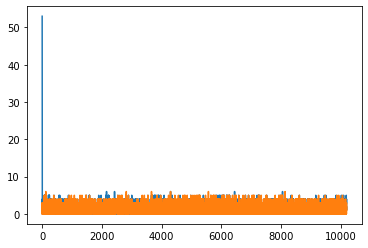

In [75]:
plt.plot(sim.flips['e'])
plt.plot(sim.flips['r'])

In [76]:
n_timesteps = 20

In [77]:
time_series = np.zeros((n_timesteps, n_rois))
state = sim.state[:]
for i in range(n_timesteps):
    state = sim.step(False, state)
    time_series[i] = state
print(np.sum(time_series))
sim_fc = 1/n_timesteps * time_series.T @ time_series 

-1760.0


In [79]:
np.sum(np.abs(sim_fc))

12819.6

In [1]:
plt.plot(sim.M)

NameError: name 'plt' is not defined

In [21]:
sim.state

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

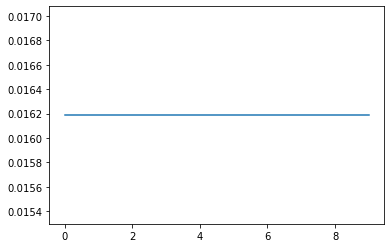

In [34]:
plt.plot(corr)

In [58]:
def corr_analysis(beta, fc):
    J = np.random.uniform(0, 1, size=(n_rois, n_rois))
    J = (J + J.T)/2 # making it symmetric
    np.fill_diagonal(J, 0)
    J_hist, f_hist = gradient_ascent(σ, J, loss, gradient, extra_param=bold_bin, learning_rate=α)
    J_max = J_hist[f_hist.index(max(f_hist))]
    sim = IsingSimulation(n_rois, beta, coupling_mat = True, J=J_max)
    for i in range(eq_steps):
        sim.step()
    _, sim_fc = sim.getTimeseries(n_timesteps)
    c = np.corrcoef(np.triu(fc).flatten(), np.triu(sim_fc).flatten())[0, 1]
    return c

In [59]:
corr_analysis(0.1, fc)

iteration: 0 loss: -125.47640610273376
iteration: 10 loss: -69.78260649664865
iteration: 20 loss: -48.010261586953774
iteration: 30 loss: -38.51514916371152
iteration: 40 loss: -32.807133888601776
iteration: 50 loss: -28.789817912803986
iteration: 60 loss: -25.73897638222778
iteration: 70 loss: -23.314915753229
iteration: 80 loss: -21.328884448760878
iteration: 90 loss: -19.66487780554901
iteration: 100 loss: -18.246531380658297
iteration: 110 loss: -17.020959443579176
iteration: 120 loss: -15.95007250460983
iteration: 130 loss: -15.005568862721349
iteration: 140 loss: -14.165879294481709
iteration: 150 loss: -13.414216575140259
iteration: 160 loss: -12.737282431113421
iteration: 170 loss: -12.124382592397357
iteration: 180 loss: -11.566804439188413
iteration: 190 loss: -11.057368925434497
iteration: 200 loss: -10.59010132094494
iteration: 210 loss: -10.159984896645478
iteration: 220 loss: -9.762773728618301
iteration: 230 loss: -9.39484842624069
iteration: 240 loss: -9.053103544131456

0.9100722069029769

In [101]:
fc = 1/n_timesteps * bold_bin.T @ bold_bin
results = Parallel(n_jobs=8)(delayed(corr_analysis)(i, fc) for i in np.linspace(0, 4, 20))

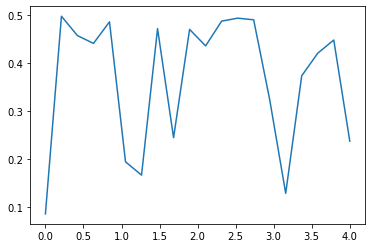

iteration: 0 loss: -1143.8887577835264
iteration: 10 loss: -1089.3616006768607
iteration: 20 loss: -1040.1259801254557
iteration: 30 loss: -995.8901156940434
iteration: 40 loss: -955.2442266969058
iteration: 50 loss: -918.6159374310795
iteration: 60 loss: -886.6750608890139
iteration: 70 loss: -859.74050046945
iteration: 80 loss: -837.8430885356095
iteration: 90 loss: -820.971252323633
iteration: 100 loss: -809.2235321918542
iteration: 110 loss: -802.9051383570652
iteration: 120 loss: -802.120856062984
iteration: 130 loss: -806.2758234974267
iteration: 140 loss: -814.6786100371173
iteration: 150 loss: -827.0957809513236
iteration: 160 loss: -843.3254045897955
iteration: 170 loss: -863.2205846839307
iteration: 180 loss: -886.2824494032145
iteration: 190 loss: -911.8789365251874
iteration: 0 loss: -1146.6466992878509
iteration: 10 loss: -1091.7581161724017
iteration: 20 loss: -1041.9534429832092
iteration: 30 loss: -997.0143001417274
iteration: 40 loss: -955.9968040366158
iteration: 50 l

iteration: 0 loss: -1159.8304830411548
iteration: 10 loss: -1104.85209669457
iteration: 20 loss: -1054.7262175375342
iteration: 30 loss: -1009.6921018226961
iteration: 40 loss: -968.5495823448146
iteration: 50 loss: -931.418351560325
iteration: 60 loss: -898.9063624508615
iteration: 70 loss: -871.4868297118242
iteration: 80 loss: -849.420620517278
iteration: 90 loss: -832.6117974565235
iteration: 100 loss: -820.8725226335893
iteration: 110 loss: -814.3262397684437
iteration: 120 loss: -813.1305141790871
iteration: 130 loss: -816.6625723054453
iteration: 140 loss: -824.4436714794065
iteration: 150 loss: -836.3841599962301
iteration: 160 loss: -852.3882009243067
iteration: 170 loss: -872.040233156782
iteration: 180 loss: -894.7851573867899
iteration: 190 loss: -920.144562602166
iteration: 0 loss: -1169.9497124917793
iteration: 10 loss: -1115.002309743749
iteration: 20 loss: -1064.7561592227557
iteration: 30 loss: -1019.7637165812481
iteration: 40 loss: -978.3748606211097
iteration: 50 lo

In [103]:
plt.plot(np.linspace(0, 4, 20), results)

In [21]:
time_series, sim_fc = sim.getTimeseries(n_timesteps)
c = np.corrcoef(np.triu(fc).flatten(), np.triu(J_hist[-2]).flatten())[0, 1]

0.35449635313285105

In [ ]:
E = []
# for T in np.linspace(1.53, 3.28, 2):
beta = 1
sim = IsingSimulation(n_rois, beta, coupling_mat = True, J=fc)
n_timesteps = 116
E1 = M1 = E2 = M2 = 0
M = []
corr = []
for i in range(eqSteps):         # equilibrate
    if i%1000 == 0:
        print(i)
        time_series, sim_fc = sim.getTimeseries(n_timesteps)
        c = np.corrcoef(np.triu(fc).flatten(), np.triu(sim_fc).flatten())[0, 1]
        corr.append(c)
    sim.step()           # Monte Carlo moves
    E.append(sim.calcEnergy())
    M.append(sim.calcMag())
plt.plot(corr)

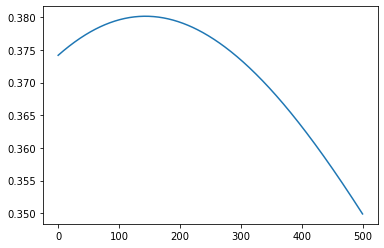

In [57]:
corr = []
for i in J_hist:
#     corr.append(loss(i, bold_bin))
    c = np.corrcoef(np.triu(fc).flatten(), np.triu(i).flatten())[0, 1]
    corr.append(c)
plt.plot(corr)

In [35]:
J = np.random.uniform(0, 1, size=(n_rois, n_rois))
J = (J + J.T)/2 # making it symmetric
np.fill_diagonal(J, 1)
gradient(J, bold_bin)

(116, 116)


array([[ 0.63941434,  0.91259763, -1.38667675, ...,  0.97732562,
        -1.271148  ,  0.80478887],
       [ 0.64981318,  0.88304238, -1.42149644, ...,  0.96666799,
        -1.29400744,  0.7888905 ],
       [-1.31800438, -1.07956325,  0.5649875 , ..., -1.07396037,
         0.73111962, -1.24096553],
       ...,
       [ 0.67193944,  0.92389227, -1.4235992 , ...,  0.91572338,
        -1.25441529,  0.77278526],
       [-1.31786791, -1.09330758,  0.5459214 , ..., -1.0628717 ,
         0.69546654, -1.24872447],
       [ 0.65624307,  0.9102043 , -1.43025217, ...,  0.93631531,
        -1.26470871,  0.73094612]])